# BRIEF
IT NOW CAN PERFORM REGRESSION AND multi class CLASSIFICATION



In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from core.ANN import Network


In [2]:

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Flatten and normalize inputs
x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0

model = Sequential([
    Dense(128, activation='tanh', input_shape=(784,), kernel_initializer='glorot_uniform'),
    Dropout(0.2),
    Dense(12, activation='tanh', kernel_initializer='glorot_uniform'),
    Dense(10, activation='softmax', kernel_initializer='glorot_uniform')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)


model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=0)


test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy on test set: {test_accuracy * 100:.2f}%")

c:\Users\ahmed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Accuracy on test set: 97.20%


In [15]:
# Define network architecture and train
neurons_each_layer = [784, 128, 12 , 10]  # Input layer, hidden layer, output layer (10 classes)
activations = ['tanh',"tanh", 'softmax']   # Activation functions for each layer
dropout = [0,0,0]  # Dropout rate of each layer [optional]

network = Network(neurons_each_layer, activations, classification=True, batchnorm=False,initialize_type="xavier", dropout=dropout)
network.train(x_train, y_train, epochs=10, batch_size=64, learning_rate=0.001, L1=0, L2=0, optimizer="adam",verbose=1)

y_pred = network.predict(x_test)
accuracy = np.mean(y_pred == y_test) * 100
print(f"Accuracy on test set: {accuracy:.2f}%") #dd



Epoch 10/10 | [██████████████████████████████████████████████████] 100.00% |  Train Loss = 0.1093
Function train took 29.4305 seconds to execute.
Accuracy on test set: 97.44%


In [13]:

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0

# Convert labels to one-hot encoding for multi-class classification
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)

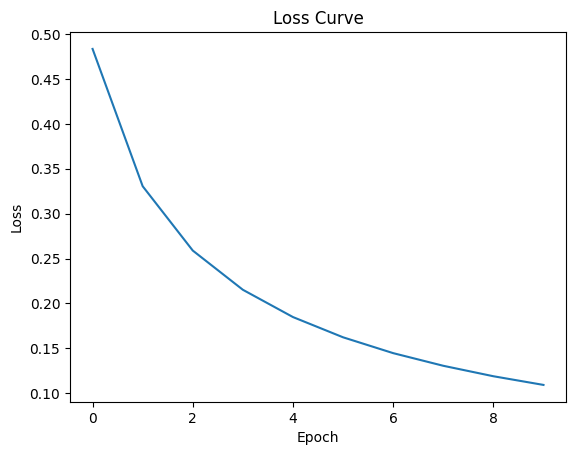

In [16]:
network.plot_loss()

some of the best accuracies i got are :

Accuracy on test set: 94.74%  (sgd)        with batchnorm

Accuracy on test set: 97.47%   (momentum)   with batchnorm

Accuracy on test set: 97.64%  (nag)        with batchnorm

Accuracy on test set: 97.93%  (rmsprop)    with batchnorm

Accuracy on test set: 94.70%  (adagrad)     with batchnorm

Accuracy on test set: 98.04%  (adam)       with batchnorm

Accuracy on test set: 97.91%  (nadam)       with batchnorm



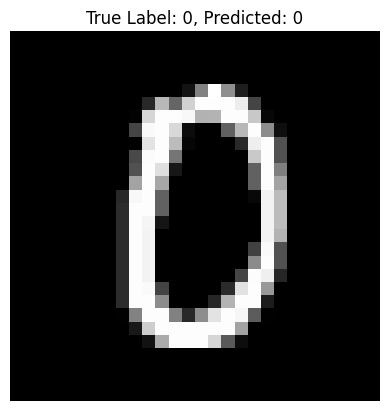

array([0], dtype=int64)

In [44]:
#this should be done with a validation set not the test set but i (استسهلت)
def display_random_image_prediction(x_data, y_data, model):
    index = np.random.randint(len(x_data))  
    image = x_data[index].reshape(28, 28)  
    label = y_data[index] 

    # Predict using the trained model
    prediction = model.predict(x_data[index:index+1])  

    plt.imshow(image, cmap='gray') 
    plt.axis('off')
    plt.title(f'True Label: {label}, Predicted: {prediction[0]}')
    plt.show()
    return prediction
# Display a random image and prediction
display_random_image_prediction(x_test, y_test, network)

In [45]:

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = train_images.reshape((-1, 28 * 28))
test_images = test_images.reshape((-1, 28 * 28))


In [46]:
import time
model = models.Sequential([
    layers.Dense(128, activation='tanh', input_shape=(784,)),
    layers.Dense(64, activation='tanh'),
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()])


start_time = time.time()
model.fit(train_images, train_labels, epochs=10, batch_size=64, validation_split=0)
end_time = time.time()
print(f'Training time: {end_time - start_time:.2f} seconds')
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')


c:\Users\ahmed\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6250 - sparse_categorical_accuracy: 0.7846
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3701 - sparse_categorical_accuracy: 0.8655
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3384 - sparse_categorical_accuracy: 0.8741
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3142 - sparse_categorical_accuracy: 0.8830
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2906 - sparse_categorical_accuracy: 0.8928
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2786 - sparse_categorical_accuracy: 0.8949
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2646 - sparse_categorical_accuracy: 0.9024
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2551 - sparse_categorical_accuracy: 0.9049
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2468 - sparse_categorical_accuracy: 0.9081
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - 

In [47]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = train_images.reshape((-1, 28 * 28))
test_images = test_images.reshape((-1, 28 * 28))
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)

In [48]:
from core.ANN import Network
neurons_each_layer = [784, 128, 64 , 10]  # Input layer, hidden layer, output layer (10 classes)
activations = ['tanh',"tanh", 'softmax']   # Activation functions for each layer
dropout = [0,0,0]  # Dropout rate of each layer

network = Network(neurons_each_layer, activations, classification=True, batchnorm=False,initialize_type="xavier", dropout=dropout)
network.train(train_images, train_labels, epochs=10, batch_size=64, learning_rate=0.001, L1=0, L2=0, optimizer="adam",verbose=1)

# Evaluate on test set
y_pred = network.predict(test_images)
accuracy = np.mean(y_pred == test_labels) 
print(f"Accuracy on test set: {accuracy:.4f}%") #dd

Epoch 10/10 | [██████████████████████████████████████████████████] 100.00% |  Train Loss = 0.3062
Function train took 36.1523 seconds to execute.
Accuracy on test set: 0.8815%


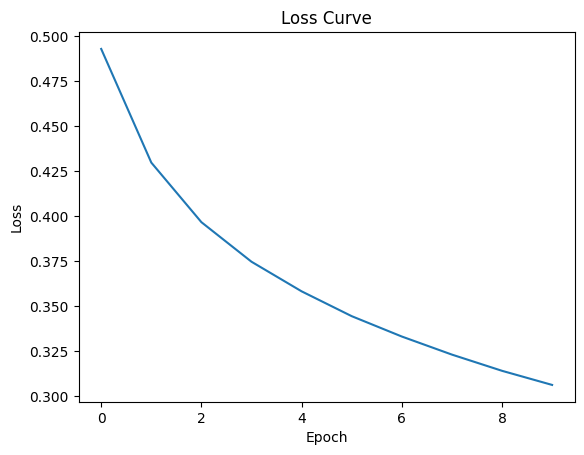

In [49]:
network.plot_loss()

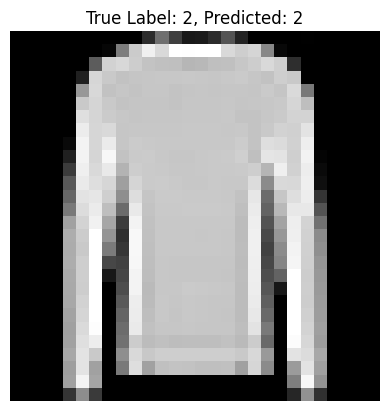

In [56]:
#this should be done with a validation set not the test set but i (استسهلت)
def display_random_image_prediction(x_data, y_data, model):
    index = np.random.randint(len(x_data))  
    image = x_data[index].reshape(28, 28)  
    label = y_data[index]  

    prediction = model.predict(x_data[index:index+1]) 
    plt.imshow(image, cmap='gray')  
    plt.axis('off')
    
    plt.title(f'True Label: {label}, Predicted: {prediction[0]}')
    plt.show()
    

display_random_image_prediction(test_images, test_labels, network)